In [ ]:


#############################################################################################
# Data Source
# https://www.kaggle.com/datasets/vinitasilaparasetty/fitzpatrick-classification-by-ethnicity
#############################################################################################


# Package Import

In [ ]:
!pip install visualkeras
!pip install opencv-python
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 13.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import visualkeras

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Data Import

In [ ]:
# USE IF RUNNING ON LOCAL MACHINE
# train_df = pd.read_csv("fitz_undersampled_train_final.csv")
# test_df = pd.read_csv("fitz_undersampled_test_final.csv")
# train_img = 'fairface/fairface/train/'
# test_img = 'fairface/fairface/val/'

In [ ]:
# If running from colab run this and below cell . ignore above cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# G-DRIVE PATH ONLY USED IF RUNNING ON COLAB / Change location yours will be different
train_df = pd.read_csv("/content/drive/MyDrive/College/Masters/Spring 2023/Deep Learning/Project/fitz_undersampled_train_final.csv")
test_df = pd.read_csv("/content/drive/MyDrive/College/Masters/Spring 2023/Deep Learning/Project/fitz_undersampled_test_final.csv")
train_img = '/content/drive/MyDrive/College/Masters/Spring 2023/Deep Learning/Project/fairface/fairface/train/'
test_img = '/content/drive/MyDrive/College/Masters/Spring 2023/Deep Learning/Project/fairface/fairface/val/'

# Cleaning

In [ ]:
train_df

,file,age,gender,race,phototype
0,1.jpg,50-59,Male,East Asian,III
1,10.jpg,30-39,Male,Middle Eastern,V
2,100.jpg,20-29,Female,East Asian,III
3,1000.jpg,30-39,Male,White,I & II
4,10004.jpg,40-49,Male,Indian,V
...,...,...,...,...,...
35425,9659.jpg,30-39,Female,Black,VI
35426,967.jpg,40-49,Female,Black,VI
35427,9676.jpg,30-39,Female,Black,VI
35428,9703.jpg,20-29,Female,Black,VI


In [ ]:
test_df

,file,age,gender,race,phototype
0,100.jpg,20-29,Female,East Asian,III
1,1000.jpg,20-29,Male,Latino_Hispanic,IV
2,10000.jpg,20-29,Female,East Asian,III
3,10001.jpg,20-29,Female,Southeast Asian,V
4,10004.jpg,20-29,Male,Southeast Asian,V
...,...,...,...,...,...
4510,9476.jpg,30-39,Female,Black,VI
4511,9501.jpg,40-49,Female,Black,VI
4512,9560.jpg,30-39,Female,Black,VI
4513,9561.jpg,20-29,Female,Black,VI


In [ ]:
# Merge train and test together for visualization
# creates Train_Test column to check if row came from train or test dataframe
#drops Train_Test since they are not needed for original train and test dataframes
train_df["Train_Test"] = "Train Data"
test_df["Train_Test"] = "Test Data"
merged_df = pd.concat([train_df,test_df], join="inner")
train_df = train_df.drop(columns=["Train_Test"])
test_df = test_df.drop(columns=["Train_Test"])
merged_df

,file,age,gender,race,phototype,Train_Test
0,1.jpg,50-59,Male,East Asian,III,Train Data
1,10.jpg,30-39,Male,Middle Eastern,V,Train Data
2,100.jpg,20-29,Female,East Asian,III,Train Data
3,1000.jpg,30-39,Male,White,I & II,Train Data
4,10004.jpg,40-49,Male,Indian,V,Train Data
...,...,...,...,...,...,...
4510,9476.jpg,30-39,Female,Black,VI,Test Data
4511,9501.jpg,40-49,Female,Black,VI,Test Data
4512,9560.jpg,30-39,Female,Black,VI,Test Data
4513,9561.jpg,20-29,Female,Black,VI,Test Data


In [ ]:
# Encodes the race string to numeric values
le = preprocessing.LabelEncoder()
train_df["race_encoded"] = le.fit_transform(train_df["race"])
test_df["race_encoded"] = le.fit_transform(test_df["race"])

In [ ]:
# Concats file name and file location together into one column
train_df["img_loc"] = train_img + train_df["file"]
test_df["img_loc"] = test_img + test_df["file"]

In [ ]:
train_df

,file,age,gender,race,phototype,race_encoded,img_loc
0,1.jpg,50-59,Male,East Asian,III,1,/content/drive/MyDrive/College/Masters/Spring ...
1,10.jpg,30-39,Male,Middle Eastern,V,4,/content/drive/MyDrive/College/Masters/Spring ...
2,100.jpg,20-29,Female,East Asian,III,1,/content/drive/MyDrive/College/Masters/Spring ...
3,1000.jpg,30-39,Male,White,I & II,6,/content/drive/MyDrive/College/Masters/Spring ...
4,10004.jpg,40-49,Male,Indian,V,2,/content/drive/MyDrive/College/Masters/Spring ...
...,...,...,...,...,...,...,...
35425,9659.jpg,30-39,Female,Black,VI,0,/content/drive/MyDrive/College/Masters/Spring ...
35426,967.jpg,40-49,Female,Black,VI,0,/content/drive/MyDrive/College/Masters/Spring ...
35427,9676.jpg,30-39,Female,Black,VI,0,/content/drive/MyDrive/College/Masters/Spring ...
35428,9703.jpg,20-29,Female,Black,VI,0,/content/drive/MyDrive/College/Masters/Spring ...


# Visualization

In [ ]:
# Histogram of Race Distribution
fig = px.histogram(merged_df, x="race", color="race", title="Distribution of Races")
fig.update_layout(xaxis_title="Race", yaxis_title="Count")

fig.update_layout(
    title={
        'text': "Distribution of Races",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        family="Arial",
        size=18,
        color="black")
)

fig.show()


In [ ]:
# Histogram of Age Distribution
fig = px.histogram(merged_df, x='age', title='Age Distribution', color="age")

fig.update_layout(xaxis_title="Age", yaxis_title="Count")

fig.update_layout(
    title={
        'text': "Age Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        family="Arial",
        size=18,
        color="black")
)

fig.show()

In [ ]:
# Histogram of Gender Distribution
fig = px.histogram(merged_df, x='gender', title='Gender Distribution', color="gender")

fig.update_layout(xaxis_title="Gender", yaxis_title="Count")

fig.update_layout(
    title={
        'text': "Gender Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        family="Arial",
        size=18,
        color="black")
)

fig.show()

In [ ]:
fig = px.pie(merged_df,"Train_Test", title="Train vs Test Data Distribution")

fig.update_layout(
    title={
        'text': "Train vs Test Data Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    font=dict(
        family="Arial",
        size=18,
        color="black")
)

fig.show()


# Model BINARY CROSSENTROPY

Built after doing research 
Used sources: tensorflow.org

Took some help on errors that i was getting from chatgpt on model below

In [ ]:
#################################

# If a machine is powerful than this can be commented
# i can't run whole train_data without either colab or my laptop taking hours, so i limited the train_df to 10,000 rows

#################################
train_df=train_df[:2000]
test_df =test_df[:400]

In [ ]:
# Define the image size, batch size, channels, epochs and classes
chnnl = 3
batch_size = 16
epoch = 10
img_size = 224
num_classes = len(np.unique(test_df["race"]))


In [ ]:
# Define the ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define the data generators for training and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="img_loc",
    y_col="race",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="img_loc",
    y_col="race",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical"
)

c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:989: UserWarning:

Found 6 invalid image filename(s) in x_col="img_loc". These filename(s) will be ignored.



Found 35424 validated image filenames belonging to 7 classes.
Found 4515 validated image filenames belonging to 7 classes.


0


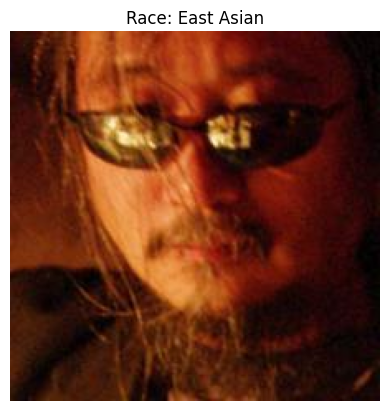

In [ ]:
test_df2 = test_df

# Convert the 'race' column to a dictionary
label_map = test_df2.set_index('race_encoded')['race'].to_dict()

# Randomly displays an image
x_batch, y_batch = test_generator.next()
rand = random.randint(0, len(x_batch)-1)
print(rand)

race_index = np.argmax(y_batch[rand])
race_label = label_map[race_index]

plt.imshow(x_batch[rand])
plt.title("Race: {}".format(race_label))
plt.axis('off')
plt.show()


In [ ]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, chnnl)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))



In [ ]:
# Compiles the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Trains the model
history = model.fit(train_generator, epochs=epoch, validation_data=test_generator, callbacks=[early_stopping])


Epoch 1/10
2214/2214 [==============================] - 319s 143ms/step - loss: 0.3844 - accuracy: 0.2917 - val_loss: 0.3656 - val_accuracy: 0.3568
Epoch 2/10
2214/2214 [==============================] - 292s 132ms/step - loss: 0.3707 - accuracy: 0.3373 - val_loss: 0.3572 - val_accuracy: 0.3903
Epoch 3/10
2214/2214 [==============================] - 305s 138ms/step - loss: 0.3599 - accuracy: 0.3701 - val_loss: 0.3417 - val_accuracy: 0.4000
Epoch 4/10
2214/2214 [==============================] - 309s 140ms/step - loss: 0.3521 - accuracy: 0.3924 - val_loss: 0.3280 - val_accuracy: 0.4481
Epoch 5/10
2214/2214 [==============================] - 310s 140ms/step - loss: 0.3463 - accuracy: 0.4041 - val_loss: 0.3253 - val_accuracy: 0.4481
Epoch 6/10
2214/2214 [==============================] - 314s 142ms/step - loss: 0.3408 - accuracy: 0.4193 - val_loss: 0.3127 - val_accuracy: 0.4824
Epoch 7/10
2214/2214 [==============================] - 312s 141ms/step - loss: 0.3357 - accuracy: 0.4271 - val_

In [ ]:
# Evaluate the model
test_loss,test_acc=model.evaluate(test_generator)

283/283 [==============================] - 6s 20ms/step - loss: 0.3185 - accuracy: 0.4671


In [ ]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
#Generates predicitons on test_data
predictions = model.predict(test_generator)

# Gets the predicted and actual labels for the test set
y_pred = np.argmax(predictions, axis=1)
y_test = test_generator.classes

283/283 [==============================] - 5s 19ms/step


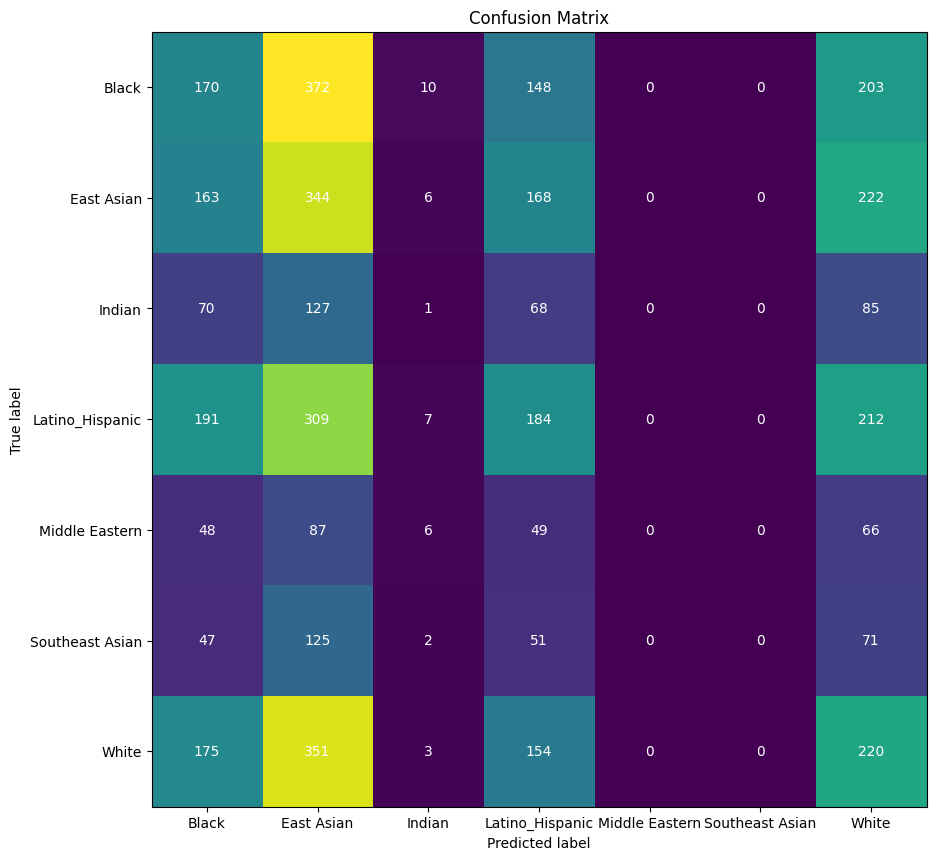

In [ ]:
# Uses the test_generator created above to generate predictions on the test set

# Creates a confusion matrix for predicted vs actual test values
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(cm)
ax.set_xticks(np.arange(len(test_generator.class_indices)))
ax.set_yticks(np.arange(len(test_generator.class_indices)))
ax.set_xticklabels(test_generator.class_indices.keys())
ax.set_yticklabels(test_generator.class_indices.keys())
for i in range(len(test_generator.class_indices)):
    for j in range(len(test_generator.class_indices)):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report precision, recall, f1-score, support

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.19      0.19       903
           1       0.20      0.38      0.26       903
           2       0.03      0.00      0.01       351
           3       0.22      0.20      0.21       903
           4       0.00      0.00      0.00       256
           5       0.00      0.00      0.00       296
           6       0.20      0.24      0.22       903

    accuracy                           0.20      4515
   macro avg       0.12      0.15      0.13      4515
weighted avg       0.17      0.20      0.18      4515



c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



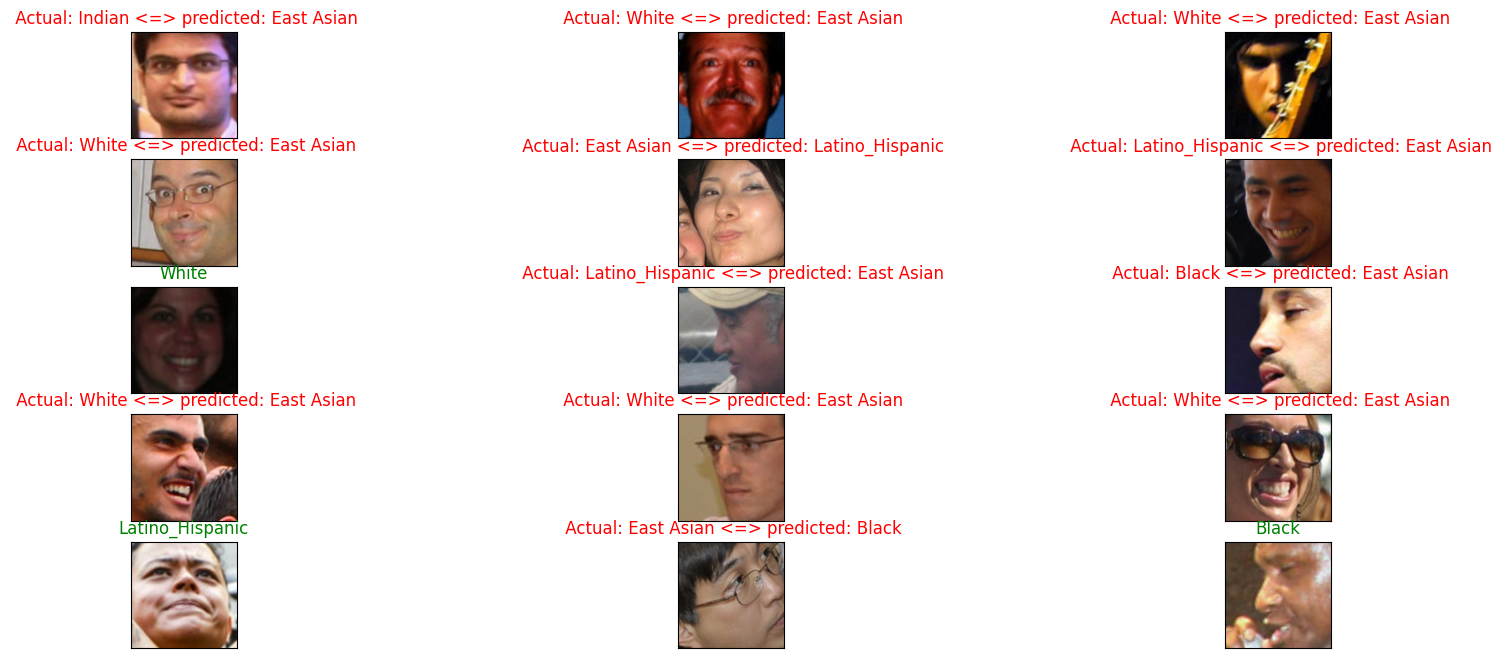

In [ ]:
# Get a batch of 15 images and their actual labels
x, y = test_generator.next()
x = x[:15]
y = y[:15]

# Convert the one-hot encoded labels to integers
y_int = np.argmax(y, axis=1)

# Convert the predicted probabilities to integers
predictions_int = np.argmax(predictions[:15], axis=1)

# Plot the images with their actual and predicted labels
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i])
    ax.set_xticks([])
    ax.set_yticks([])
    actual_label = label_map[y_int[i]]
    predicted_label = label_map[predictions_int[i]]
    if actual_label == predicted_label:
        ax.set_title(actual_label, color='green')
    else:
        ax.set_title(f' Actual: {actual_label} <=> predicted: {predicted_label}', color='red')
plt.show()


# MODEL CATEGORICAL CROSSENTROPY

In [ ]:
# Define the image size, batch size, channels, epochs and classes
chnnl_1 = 3
batch_size_1 = 16
epoch_1 = 3
img_size_1 = 224
num_classes_1 = len(np.unique(test_df["race"]))

# Define the ImageDataGenerator for data augmentation
train_datagen_1 = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen_1 = ImageDataGenerator(rescale=1./255)

# Define the data generators for training and testing
train_generator_1 = train_datagen_1.flow_from_dataframe(
    dataframe=train_df,
    x_col="img_loc",
    y_col="race",
    target_size=(img_size_1, img_size_1),
    batch_size=batch_size_1,
    class_mode="categorical"
)

test_generator_1 = test_datagen_1.flow_from_dataframe(
    dataframe=test_df,
    x_col="img_loc",
    y_col="race",
    target_size=(img_size_1, img_size_1),
    batch_size=batch_size_1,
    class_mode="categorical"
)

# Define the CNN model_1 architecture
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size_1, img_size_1, chnnl_1)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Conv2D(256, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes_1, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EarlyStopping callback to prevent overfitting
early_stopping_1 = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Trains the model_1
history_1 = model_1.fit(train_generator_1, epochs=epoch_1, validation_data=test_generator_1, callbacks=[early_stopping_1])

model_1.evaluate(test_generator_1)



Epoch 1/3
2214/2214 [==============================] - 313s 141ms/step - loss: 1.8394 - accuracy: 0.2008 - val_loss: 1.8297 - val_accuracy: 0.2000
Epoch 2/3
2214/2214 [==============================] - 307s 139ms/step - loss: 1.8314 - accuracy: 0.1979 - val_loss: 1.8288 - val_accuracy: 0.2000
Epoch 3/3
283/283 [==============================] - 6s 20ms/step - loss: 1.8278 - accuracy: 0.2000


[1.8277949094772339, 0.20000000298023224]

In [ ]:
# Summary of the model
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
#Generates predicitons on test_data
predictions1 = model_1.predict(test_generator_1)

# Gets the predicted and actual labels for the test set
y_pred1 = np.argmax(predictions1, axis=1)
y_test1 = test_generator_1.classes

283/283 [==============================] - 6s 19ms/step


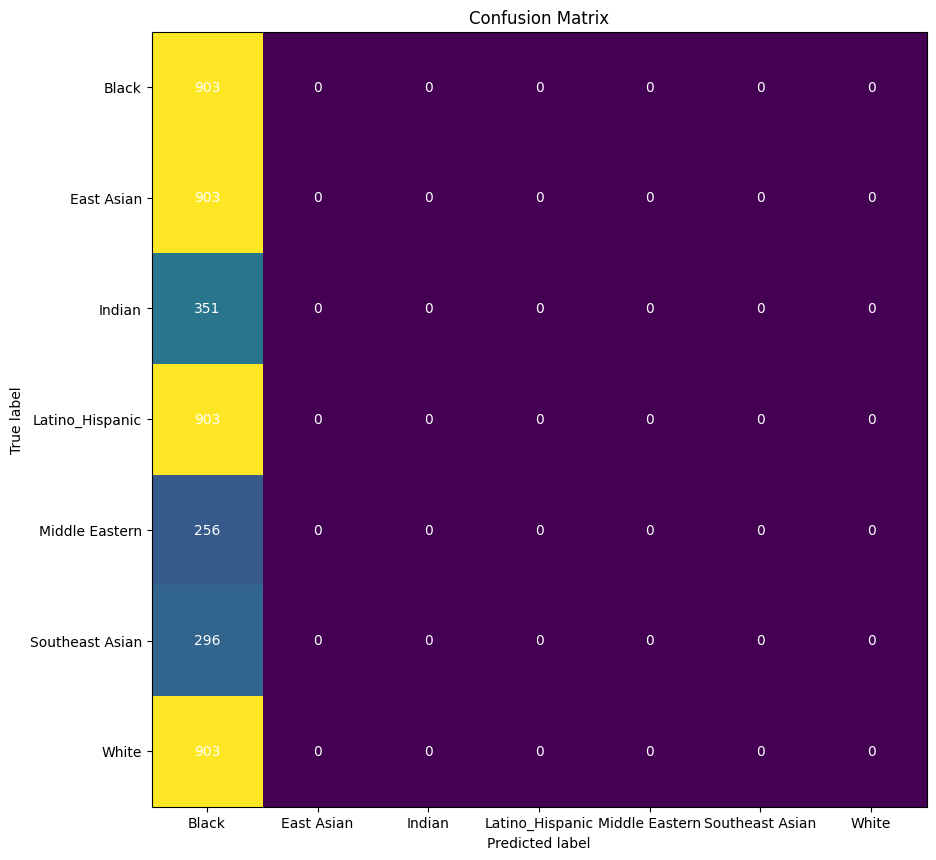

In [ ]:
# Uses the test_generator_1 created above to generate predictions on the test set

# Creates a confusion matrix for predicted vs actual test values
cm1 = confusion_matrix(y_test1, y_pred1)

fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(cm1)
ax.set_xticks(np.arange(len(test_generator_1.class_indices)))
ax.set_yticks(np.arange(len(test_generator_1.class_indices)))
ax.set_xticklabels(test_generator_1.class_indices.keys())
ax.set_yticklabels(test_generator_1.class_indices.keys())
for i in range(len(test_generator_1.class_indices)):
    for j in range(len(test_generator_1.class_indices)):
        ax.text(j, i, cm1[i, j], ha="center", va="center", color="white")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report precision, recall, f1-score, support

print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33       903
           1       0.00      0.00      0.00       903
           2       0.00      0.00      0.00       351
           3       0.00      0.00      0.00       903
           4       0.00      0.00      0.00       256
           5       0.00      0.00      0.00       296
           6       0.00      0.00      0.00       903

    accuracy                           0.20      4515
   macro avg       0.03      0.14      0.05      4515
weighted avg       0.04      0.20      0.07      4515



c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\u92kh\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



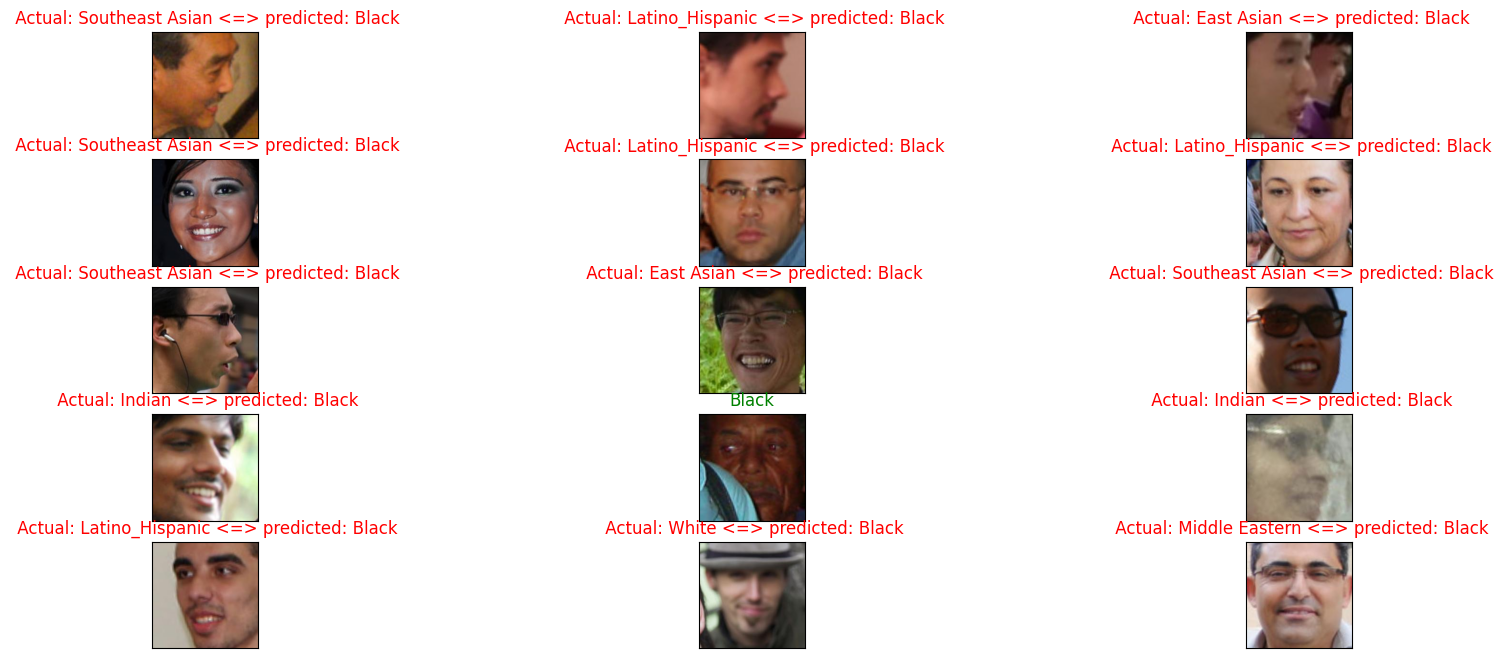

In [ ]:
# Get a batch of 15 images and their actual labels
x, y = test_generator.next()
x = x[:15]
y = y[:15]

# Convert the one-hot encoded labels to integers
y_int = np.argmax(y, axis=1)

# Convert the predicted probabilities to integers
predictions1_int = np.argmax(predictions1[:15], axis=1)

# Plot the images with their actual and predicted labels
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i])
    ax.set_xticks([])
    ax.set_yticks([])
    actual_label = label_map[y_int[i]]
    predicted_label = label_map[predictions1_int[i]]
    if actual_label == predicted_label:
        ax.set_title(actual_label, color='green')
    else:
        ax.set_title(f' Actual: {actual_label} <=> predicted: {predicted_label}', color='red')
plt.show()


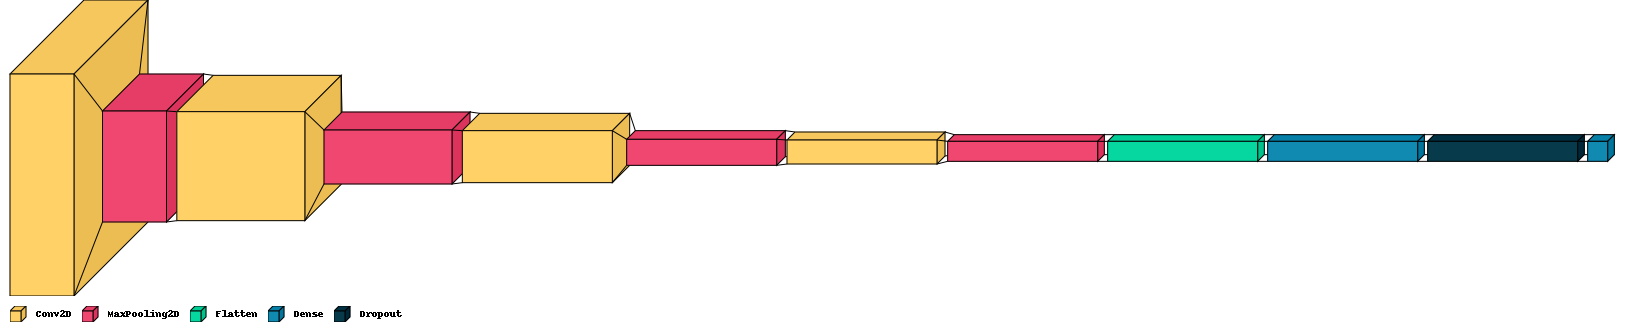

In [ ]:
# CNN Model Structure
visualkeras.layered_view(model, legend=True, scale_xy=1, scale_z=2, max_z=150)